<a href="https://colab.research.google.com/github/chugcha/hw_proga/blob/main/hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 2**

# Загрузка книги и всего остального

In [3]:
!pip install pymystem3 --q
!pip install nltk --q
!pip install pymorphy3 --q
!pip install spacy --q
!pip install typing_extensions --upgrade --q
!python -m spacy download ru_core_news_sm --q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 73.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
!wget https://raw.githubusercontent.com/chugcha/hw_proga/refs/heads/main/bazhov1tom.txt
# Это файл из моего репозитория на гитхабе

with open('bazhov1tom.txt', 'r') as file:
   book_not_lower = file.read()
   book = book_not_lower.lower()

--2025-10-31 19:38:09--  https://raw.githubusercontent.com/chugcha/hw_proga/refs/heads/main/bazhov1tom.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 917244 (896K) [text/plain]
Saving to: ‘bazhov1tom.txt’

bazhov1tom.txt      100%[===================>] 895.75K  --.-KB/s    in 0.1s    

2025-10-31 19:38:09 (8.66 MB/s) - ‘bazhov1tom.txt’ saved [917244/917244]



# NLTK + Pymorphy

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt_tab')

book_tokens = word_tokenize(book, language='russian')
sw = stopwords.words('russian')

dirty_words = [w.lower() for w in book_tokens if w.isalpha()]
clean_words = [w for w in dirty_words if w not in sw]
# теперь в clean_words остались только все не-стоп-слова

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
import json
from pymorphy3 import MorphAnalyzer
from pprint import pprint

morph = MorphAnalyzer()

ana_w = [morph.parse(word) for word in clean_words]
# здесь записаны все возможные разборы слов из текста

with open('analysed_tokens_pymorphy.jsonl', 'w', encoding='utf-8') as f:
    for i in ana_w:
        token_data = {"word": i[0].word, "lemma": i[0].normalized.word, "pos": i[0].tag.POS}
        f.write(json.dumps(token_data) + '\n')

# теперь всё есть в json файле, смотрите:

with open('analysed_tokens_pymorphy.jsonl', 'r', encoding='utf-8') as k:
    for i in range(6):
        print(json.loads(k.readline()))

{'word': 'бажов', 'lemma': 'баж', 'pos': 'NOUN'}
{'word': 'павел', 'lemma': 'павел', 'pos': 'NOUN'}
{'word': 'собрание', 'lemma': 'собрание', 'pos': 'NOUN'}
{'word': 'сочинений', 'lemma': 'сочинение', 'pos': 'NOUN'}
{'word': 'трёх', 'lemma': 'три', 'pos': 'NUMR'}
{'word': 'томах', 'lemma': 'том', 'pos': 'NOUN'}


In [7]:
#заносим информацию по каждой лемме в словарик для конвертирования в датафрейм
data_dict = {'lemmas': [], 'pos': [], 'frequency': []}

for i in ana_w:
  if i[0].normalized.word not in data_dict['lemmas']: # добавляем уникальную лемму
      data_dict['lemmas'].append(i[0].normalized.word)
      data_dict['pos'].append(i[0].normalized.tag.POS)
      data_dict['frequency'].append(1)

  else:
      # оказалось, бывает, что одну лемму определяют как разные части речи
      if data_dict['pos'][data_dict['lemmas'].index(i[0].normalized.word)] != i[0].normalized.tag.POS:
          same_lemmas_POS = []
          same_lemmas = [j for j, item in enumerate(data_dict['lemmas']) if item == i[0].normalized.word]
          for m in same_lemmas:
              same_lemmas_POS.append(data_dict['pos'][m])
          if i[0].normalized.tag.POS not in same_lemmas_POS:
              data_dict['lemmas'].append(i[0].normalized.word)
              data_dict['pos'].append(i[0].normalized.tag.POS)
              data_dict['frequency'].append(1)
      else:
          data_dict['frequency'][data_dict['lemmas'].index(i[0].normalized.word)] += 1
# это на всякий случай, проверить, что работает
print('Всего лексем:', len(data_dict['lemmas']))
print('Абсолютная частота вхождений лексемы "кошка":', data_dict['frequency'][data_dict['lemmas'].index('кошка')])


Всего лексем: 7836
Абсолютная частота вхождений лексемы "кошка": 37


In [8]:
import pandas as pd
bazhov_df = pd.DataFrame(data_dict)
print(bazhov_df.info())
print('\n')
#видно, что у некоторых слов не хватает каких-то значений POS. Выведем их
words_without_pos = bazhov_df[bazhov_df['pos'].isna()]
print(f"Слова без части речи: {len(words_without_pos)}")
print(words_without_pos['lemmas'].to_list())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7836 entries, 0 to 7835
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lemmas     7836 non-null   object
 1   pos        7820 non-null   object
 2   frequency  7836 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 183.8+ KB
None


Слова без части речи: 16
['постеля', 'пировля', 'ина', 'гож', 'дедко', 'полишку', 'задохся', 'ремки', 'нелзя', 'еси', 'заделья', 'деревнешка', 'гач', 'кго', 'деревнл', 'эку']


In [9]:
sorted_df = bazhov_df.sort_values('frequency', ascending=False)
print(sorted_df)

           lemmas   pos  frequency
41          стать  INFN        530
122      говорить  INFN        509
131           это  PRCL        442
295           тот  ADJF        375
192          дело  NOUN        311
...           ...   ...        ...
7818      площадь  NOUN          1
7817  понаторкать  INFN          1
7816      знаться  INFN          1
7815   замкнуться  INFN          1
7814     остатный  ADJF          1

[7836 rows x 3 columns]


In [10]:
import csv

sorted_df.to_csv('pymorphy_frequency.csv')

# Spacy

In [11]:
import spacy
from spacy.lang.ru.examples import sentences


nlp = spacy.load('ru_core_news_sm')

In [12]:
# очищаем текст от всего ненужного

cleaned_book = []
doc_sad = nlp(book)
for token in doc_sad:
  if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit:
      cleaned_book.append(token.text)
doc_happy = nlp(' '.join(clean_words))

In [13]:
print(cleaned_book[:10])

['бажов', 'павел', 'собрание', 'сочинений', 'трех', 'сказки', 'медной', 'горы', 'хозяйка', 'пошли']


In [14]:
# так же, как было с pymorphy и nltk
with open('analysed_tokens_spacy.jsonl', 'w', encoding='utf-8') as f:
    for token in doc_happy:
        token_data = {"word": token.text, "lemma": token.lemma_, "pos": token.pos_}
        f.write(json.dumps(token_data) + '\n')

# вроде бы всё на месте
with open('analysed_tokens_spacy.jsonl', 'r', encoding='utf-8') as k:
    for i in range(6):
        print(json.loads(k.readline()))

{'word': 'бажов', 'lemma': 'бажов', 'pos': 'NOUN'}
{'word': 'павел', 'lemma': 'павел', 'pos': 'VERB'}
{'word': 'собрание', 'lemma': 'собрание', 'pos': 'NOUN'}
{'word': 'сочинений', 'lemma': 'сочинение', 'pos': 'NOUN'}
{'word': 'трех', 'lemma': 'три', 'pos': 'NUM'}
{'word': 'томах', 'lemma': 'том', 'pos': 'NOUN'}


In [15]:
# делаем всё аналогично с pymorph
data_dict_sp = {'lemmas': [], 'pos': [], 'frequency': []}

for token in doc_happy:
  if token.lemma_ not in data_dict_sp['lemmas']: # добавляем уникальную лемму
      data_dict_sp['lemmas'].append(token.lemma_)
      data_dict_sp['pos'].append(token.pos_)
      data_dict_sp['frequency'].append(1)

  else:
      # оказалось, бывает, что одну лемму определяют как разные части речи
      if data_dict_sp['pos'][data_dict_sp['lemmas'].index(token.lemma_)] != token.pos_:
          same_lemmas_POS = []
          same_lemmas = [j for j, item in enumerate(data_dict_sp['lemmas']) if item == token.lemma_]
          for m in same_lemmas:
              same_lemmas_POS.append(data_dict_sp['pos'][m])
          if token.pos_ not in same_lemmas_POS:
              data_dict_sp['lemmas'].append(token.lemma_)
              data_dict_sp['pos'].append(token.pos_)
              data_dict_sp['frequency'].append(1)
      else:
          data_dict_sp['frequency'][data_dict_sp['lemmas'].index(token.lemma_)] += 1
# это на всякий случай, проверить, что работает
print('Всего лексем:', len(data_dict_sp['lemmas']))
print('Абсолютная частота вхождений лексемы "кошка":', data_dict_sp['frequency'][data_dict_sp['lemmas'].index('кошка')])


Всего лексем: 11623
Абсолютная частота вхождений лексемы "кошка": 37


In [16]:
bazhov_sp = pd.DataFrame(data_dict_sp)
print(bazhov_sp.info(), '\n')

sorted_df_sp = bazhov_sp.sort_values('frequency', ascending=False)
print('А вот и частотность: \n')
print(sorted_df_sp)

sorted_df_sp.to_csv('spacy_frequency.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11623 entries, 0 to 11622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lemmas     11623 non-null  object
 1   pos        11623 non-null  object
 2   frequency  11623 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 272.5+ KB
None 

А вот и частотность: 

            lemmas   pos  frequency
42           стать  VERB        504
125       говорить  VERB        499
311            тот   DET        353
134            это  PRON        338
107          место  NOUN        290
...            ...   ...        ...
20     праздничный  VERB          1
11607       угадаю  VERB          1
11608    болботать   ADV          1
11609      одинова   ADJ          1
11594   огромадная   ADJ          1

[11623 rows x 3 columns]


# Анализ частотности морфем

In [17]:
print('Количество лексем из анализа pymorphy: ', bazhov_df.shape[0])
print('Количество лексем из анализа spacy: ', bazhov_sp.shape[0], '\n')

print('Набор морфем pymorph: ', bazhov_df["pos"].unique(), '\n')
print('Набор морфем spacy: ', bazhov_sp["pos"].unique())

Количество лексем из анализа pymorphy:  7836
Количество лексем из анализа spacy:  11623 

Набор морфем pymorph:  ['NOUN' 'NUMR' 'ADJF' 'INFN' 'ADVB' 'CONJ' 'PREP' 'NPRO' 'PRCL' 'PRED'
 'INTJ' None 'ADJS' 'VERB'] 

Набор морфем spacy:  ['NOUN' 'VERB' 'NUM' 'ADJ' 'DET' 'ADV' 'PROPN' 'ADP' 'PRON' 'PART' 'CCONJ'
 'AUX' 'SCONJ' 'X']


In [39]:
# получились некрасивые наборы, приведём их к общему виду:
def rename_pos_pymorphy(pos):
    pos_str = str(pos)
    if pos is None:
      return 'X'
    elif pos == 'NUMR':
        return 'NUM'
    elif pos == 'ADJF' or pos == 'ADJS':
        return 'ADJ'
    elif pos == 'NPRO':
        return 'PRON'
    elif pos == 'INFN':
        return 'VERB'
    elif pos == 'ADVB':
        return 'ADV'
    elif pos == 'PRCL':
        return 'PART'
    else:
        return pos_str

def rename_pos_spacy(pos):
    pos_str = str(pos)
    if pos == 'CCONJ' or pos == 'SCONJ':
        return 'CONJ'
    elif pos == 'PROPN':
        return 'NOUN'
    elif pos == 'ADP':
        return 'PREP'
    elif pos == 'AUX':
        return 'PRED'
    elif pos == 'DET':
        return 'ADJ'
    else:
        return pos_str

bazhov_df["pos"] = bazhov_df["pos"].apply(rename_pos_pymorphy)
bazhov_sp["pos"] = bazhov_sp["pos"].apply(rename_pos_spacy)

print('Новый набор морфем pymorph: ', bazhov_df["pos"].unique(), '\n')
print('Новый набор морфем spacy: ', bazhov_sp["pos"].unique())

# Получилось, что у нас в pymprph также выделены междометия,
# которые в spacy были удалены как стоп-слова. Но я не хочу исключать их из анализа и оставлю.

Новый набор морфем pymorph:  ['NOUN' 'NUM' 'ADJ' 'VERB' 'ADV' 'CONJ' 'PREP' 'PRON' 'PART' 'PRED' 'INTJ'
 'X'] 

Новый набор морфем spacy:  ['NOUN' 'VERB' 'NUM' 'ADJ' 'ADV' 'PREP' 'PRON' 'PART' 'CONJ' 'PRED' 'X']


In [19]:
def count_frec_pm(whatever):
   return (int(whatever) / len(clean_words))

def count_frec_sp(whatever):
   return (int(whatever) / len(cleaned_book))

morph_freq_pm = bazhov_df.groupby('pos')['frequency'].sum()
morph_freq_sp = bazhov_sp.groupby('pos')['frequency'].sum()
morph_freq_pm = morph_freq_pm.apply(count_frec_pm).sort_values(ascending=False)
morph_freq_sp = morph_freq_sp.apply(count_frec_sp).sort_values(ascending=False)
morph_freq_pm = morph_freq_pm.round(5)
morph_freq_sp = morph_freq_sp.round(5)

print('Доля частей речи по pymorph:')
print(morph_freq_pm, '\n')
print('Доля частей речи по spacy:')
print(morph_freq_sp)

Доля частей речи по pymorph:
pos
NOUN    0.38251
VERB    0.34367
ADJ     0.14784
ADV     0.06233
CONJ    0.01612
PART    0.01462
PRON    0.01328
NUM     0.00563
PREP    0.00376
INTJ    0.00327
PRED    0.00246
X       0.00130
Name: frequency, dtype: float64 

Доля частей речи по spacy:
pos
NOUN    0.43506
VERB    0.35806
ADJ     0.13571
ADV     0.07506
PRON    0.02682
NUM     0.01014
PART    0.00586
PREP    0.00344
PRED    0.00281
CONJ    0.00232
X       0.00002
Name: frequency, dtype: float64


По этим данным можно сделать несколько выводов. Во-первых, количество выделенных сушествительных, глаголов, прилагательных и наречий примерно равно, наибольшее сходство есть в частотности глаголов. Та разница, которая видна в доле существительных, прилагательных и местоимений, вероятно, возникла из-за того, что pymorph оказался менее чувствительным к формам, которые spacy смог определить, либо из-за того, что spacy определил их как существительные, что объясняет их большую долю в анализе spacy. То, что spacy выделяет большее количество местоимений, объясняется особенностью фильтрации стоп-слов, которые он применял.

# Визуализация 1

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [21]:
X_pm = morph_freq_pm.index.tolist()
Y_pm = morph_freq_pm.values.tolist()

X_sp = morph_freq_sp.index.tolist()
Y_sp = morph_freq_sp.values.tolist()

print('Pymorphy: \n', X_pm, '\n', Y_pm, '\n')
print('Spacy: \n', X_sp, '\n', Y_sp)

Pymorphy: 
 ['NOUN', 'VERB', 'ADJ', 'ADV', 'CONJ', 'PART', 'PRON', 'NUM', 'PREP', 'INTJ', 'PRED', 'X'] 
 [0.38251, 0.34367, 0.14784, 0.06233, 0.01612, 0.01462, 0.01328, 0.00563, 0.00376, 0.00327, 0.00246, 0.0013] 

Spacy: 
 ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'NUM', 'PART', 'PREP', 'PRED', 'CONJ', 'X'] 
 [0.43506, 0.35806, 0.13571, 0.07506, 0.02682, 0.01014, 0.00586, 0.00344, 0.00281, 0.00232, 2e-05]


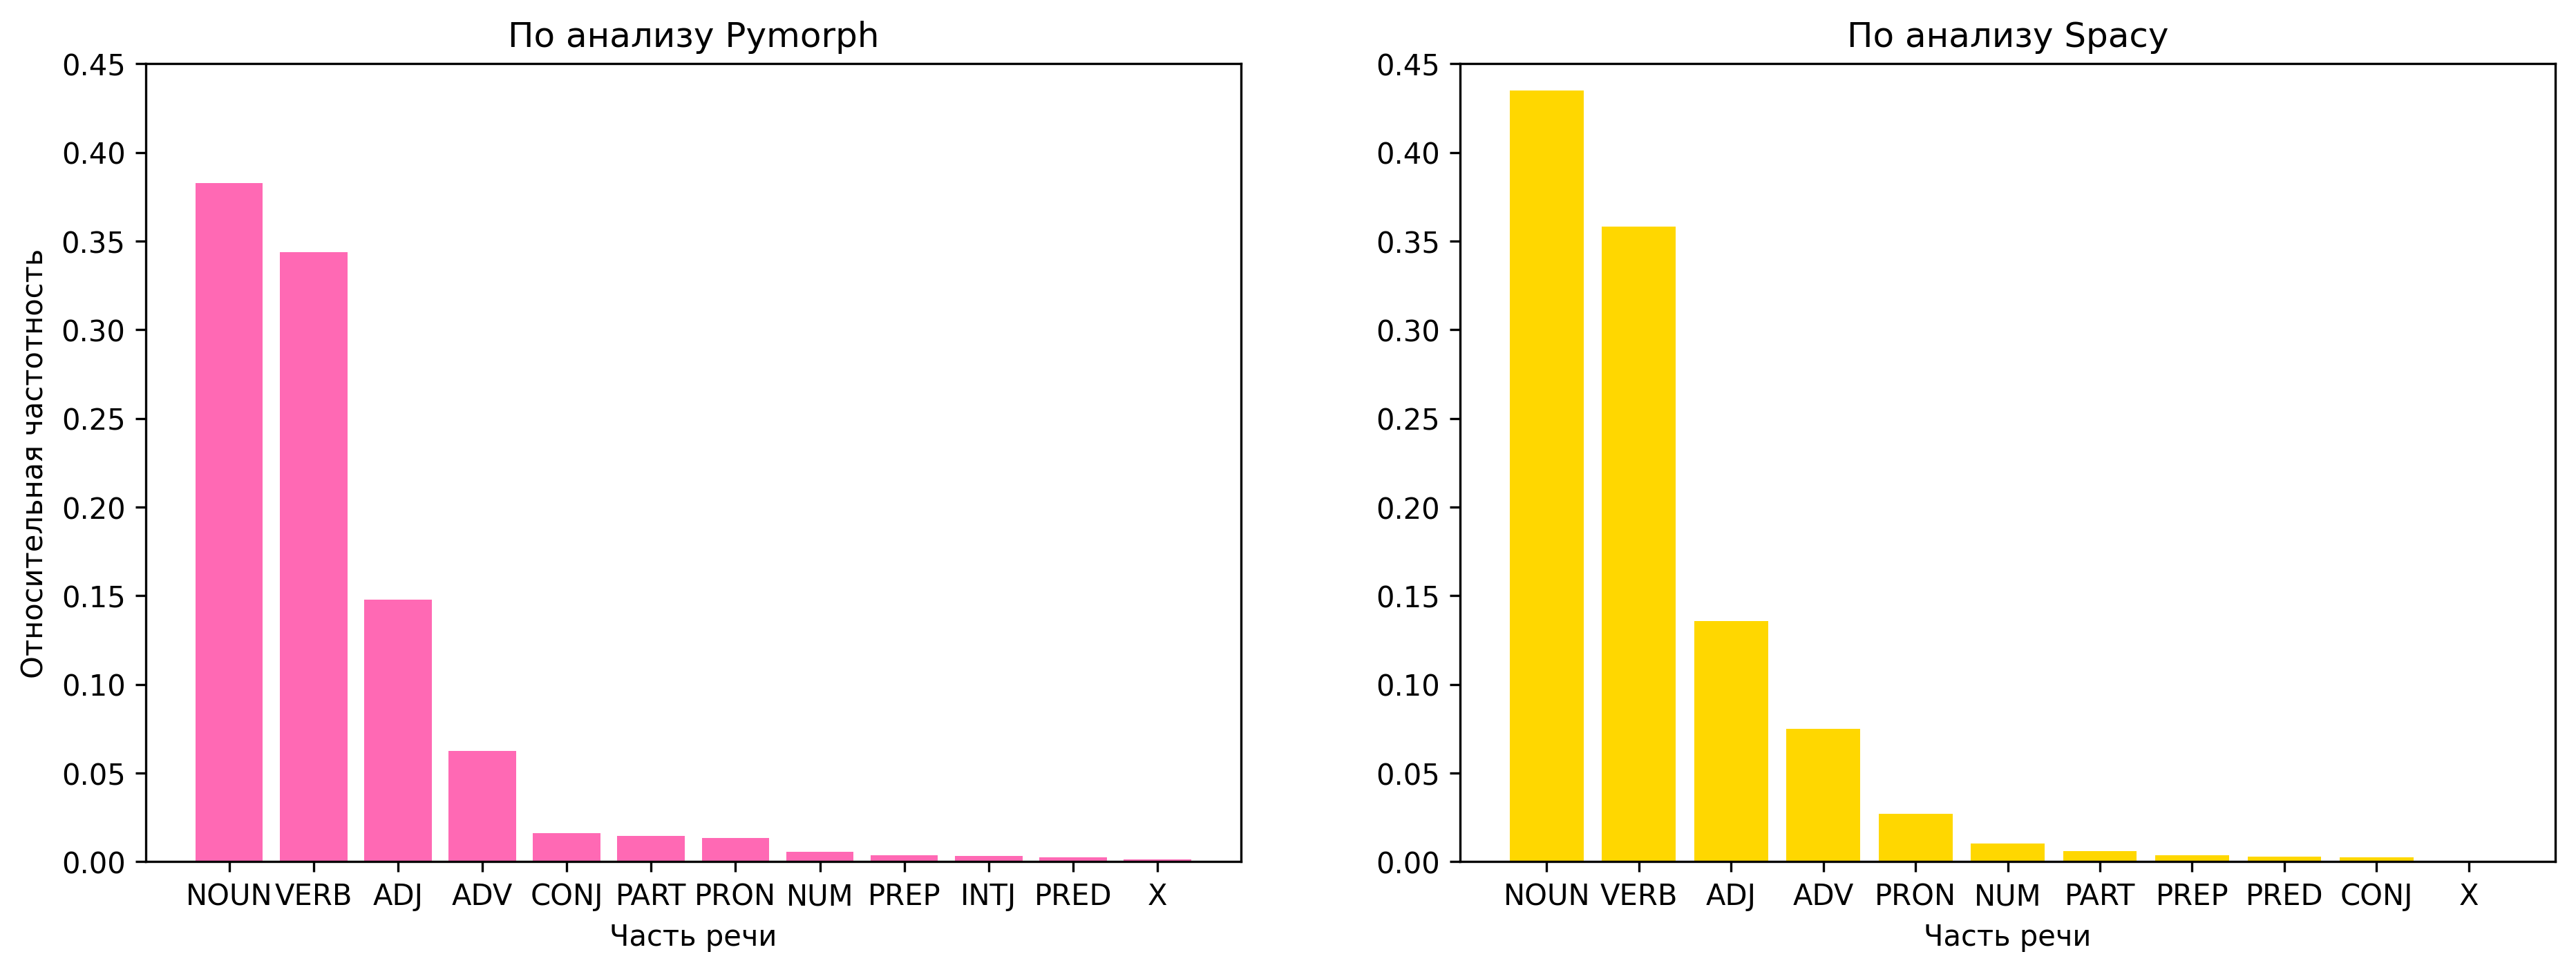

In [22]:
plt.figure(figsize=(15, 5), dpi=300)\

plt.subplot(1, 2, 1)
plt.title('По анализу Pymorph')
plt.ylabel('Относительная частотность')
plt.xlabel('Часть речи')
plt.bar(X_pm, Y_pm, color='hotpink')
plt.xticks(ticks=X_pm, labels=X_pm)
plt.ylim(0, 0.45)

plt.subplot(1, 2, 2)
plt.title('По анализу Spacy')
plt.xlabel('Часть речи')
plt.bar(X_sp, Y_sp, color='gold')
plt.xticks(ticks=X_sp, labels=X_sp)
plt.ylim(0, 0.45)

plt.show()

# Визуализация 2

In [49]:
frequent_verbs_pm = bazhov_df[bazhov_df['pos'].isin(['VERB', 'INFN'])].groupby('lemmas')['frequency'].sum()
top20_verbs_pm = frequent_verbs_pm.sort_values(ascending=False).head(20)

frequent_adv_pm = bazhov_df[bazhov_df['pos'].apply(str) == 'ADV'].groupby('lemmas')['frequency'].sum()
top20_adv_pm = frequent_adv_pm.sort_values(ascending=False).head(20)

verbs_sp = bazhov_sp[bazhov_sp['pos'] == 'VERB'].groupby('lemmas')['frequency'].sum()
top20_verbs_sp = verbs_sp.sort_values(ascending=False).head(20)

adv_sp = bazhov_sp[bazhov_sp['pos'] == 'ADV'].groupby('lemmas')['frequency'].sum()
top20_adv_sp = adv_sp.sort_values(ascending=False).head(20)

In [50]:
comparison_df = pd.DataFrame({
    'Pymorphy_VERB': top20_verbs_pm.index,
    'Count_Pymorphy': top20_verbs_pm.values,
    'Spacy_VERB': top20_verbs_sp.index,
    'Count_Spacy': top20_verbs_sp.values})

print(comparison_df.to_string(index=False))

Pymorphy_VERB  Count_Pymorphy Spacy_VERB  Count_Spacy
        стать             530      стать          504
     говорить             509   говорить          499
       видеть             263     видеть          259
        пойти             240      пойти          252
      сказать             206     думать          179
       думать             184    сказать          179
        знать             178      знать          150
      глядеть             173      выйти          140
       давать             155   отвечать          131
        выйти             143 спрашивать          128
    поглядеть             133    глядеть          119
     отвечать             132     сидеть          107
   спрашивать             130      найти           99
        взять             127     прийти           97
       сидеть             111      взять           95
         идти             104       жить           94
        найти              97     давать           92
         жить              9

Списки достаточно сильно различаются: в pymorphy в целом выше частотность глаголов из топ-20, возможно, потому что я привела все инфинитивы в глаголы, а в spacy некоторые инфинитивы могли быть засчитаны за другие части речи из-за синтаксиса. Но, что интересно, первый и последний глаголы обоих списков одинаковые. Ещё из интересного - spacy определил "дескать" как глагол из-за того, что автоматически выделил в нём глагольные морфемы.

In [51]:
comparison_df = pd.DataFrame({
    'Pymorphy_ADV': top20_adv_pm.index,
    'Count_Pymorphy': top20_adv_pm.values,
    'Spacy_ADV': top20_adv_sp.index,
    'Count_Spacy': top20_adv_sp.values})

print(comparison_df.to_string(index=False))

Pymorphy_ADV  Count_Pymorphy Spacy_ADV  Count_Spacy
       вовсе             256     вовсе          256
    маленько             100     видно          196
       домой              96     домой           96
       ровно              91  маленько           95
       сразу              86     ровно           91
      сперва              75     сразу           86
         вон              62    сперва           75
     сколько              57   далёкий           62
     понятно              53      мало           57
       прямо              50     прямо           50
       давно              48   понятно           49
      близко              42     давно           48
       сколь              40    близко           42
       шибко              39     сколь           36
       однём              34      туда           34
        туда              34     верно           32
      кругом              30     дедко           31
        живо              29    плохой           31
      откуда

Видно, что spacy выделил "видно" как наречие, хотя обычно мы его определяем как вводное слово, что, очевидно, и сделал pymorphy. Похоже, pymorphy берет только те слова, которые точно являются наречиями. А spacy помечает как наречия почти всё, что в тексте стоит в роли обстоятельства, даже если это другие части речи. Ещё spacy ориентируется на свой собственный морфемный анализ незнакомых слов: он определяет всё, что на "о", как наречия, например, "дедко". При этом почему-то "далёкий" тоже записал в наречия. А ещё pymorphy лучше понимает архаизмы и регионализмы, и вообще люебую непривычную лексику из бажовских сказов, в то время как spacy их часто не узнает.

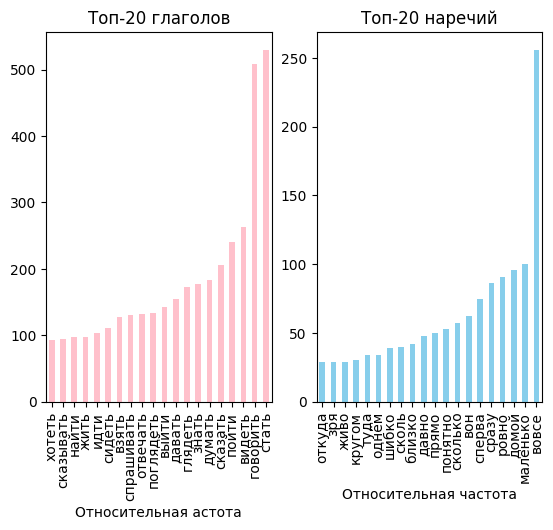

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2)

top20_verbs_pm.sort_values().plot(kind='bar', ax=ax1, color='pink')
ax1.set_title('Топ-20 глаголов')
ax1.set_xlabel('Относительная астота')

top20_adv_pm.sort_values().plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Топ-20 наречий')
ax2.set_xlabel('Относительная частота')

plt.show()

# Визуализация 3

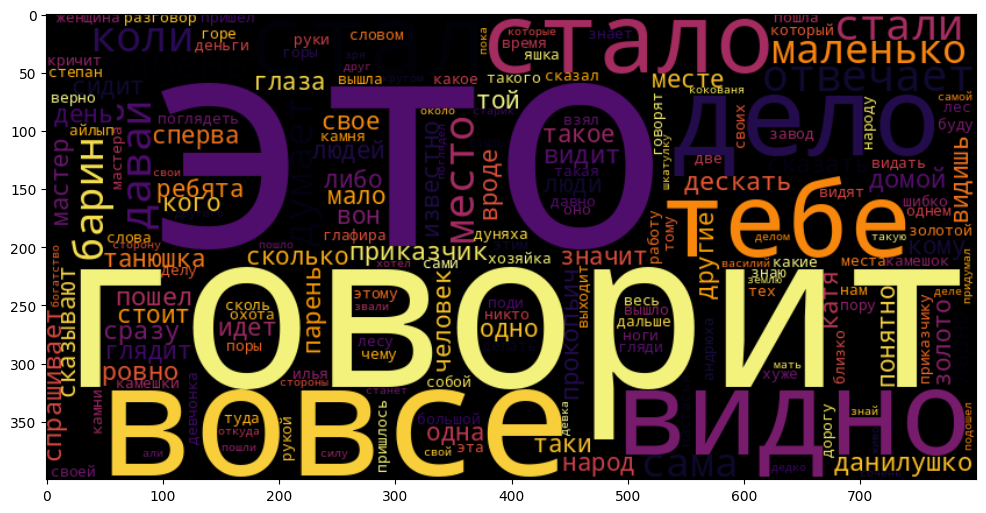

In [71]:
tokenized_text = ' '.join(clean_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='inferno',
    min_word_length=3,
    collocations=False
).generate(tokenized_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')

plt.show()
# Это для токенизированного текста

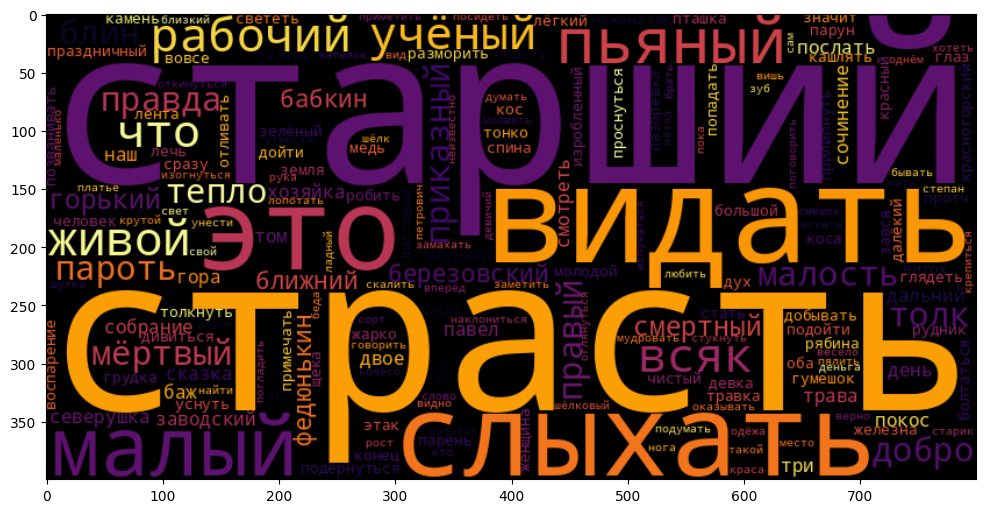

In [73]:
lemmatized_text = ' '.join(bazhov_df['lemmas'].astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='inferno',
    min_word_length=3,
    collocations=False
).generate(lemmatized_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')

plt.show()
# Это для лемматизированного текста

# Би-три-граммы

In [80]:
from nltk import bigrams, trigrams
from collections import Counter

def lemmatize_word(word):
    parsed = morph.parse(word)[0]
    return parsed.normal_form

lemmas = [lemmatize_word(word) for word in clean_words]

bigrams_list = list(bigrams(lemmas))
trigrams_list = list(trigrams(lemmas))

bigrams_freq = Counter(bigrams_list)
trigrams_freq = Counter(trigrams_list)

top25_bigrams = bigrams_freq.most_common(25)
print("Топ-25 биграмм:")
for bigram, freq in top25_bigrams:
    print(f"{bigram[0]} {bigram[1]}: {freq}")

print("\n")

top25_trigrams = trigrams_freq.most_common(25)
print("Топ-25 триграмм:")
for trigram, freq in top25_trigrams:
    print(f"{trigram[0]} {trigram[1]} {trigram[2]}: {freq}")

Топ-25 биграмм:
тот пора: 62
однём слово: 34
голубой змейка: 30
дедко ефим: 24
первый дело: 21
золотой волос: 20
это говорить: 19
старый человек: 18
наш завод: 17
который место: 17
это дело: 15
тот место: 14
это место: 14
серебряный копытце: 14
друг дружка: 13
тот сторона: 13
медный гора: 12
говорить это: 12
тот год: 12
говорить ладный: 12
это отвечать: 12
прямо сказать: 11
хозяйка гора: 11
думный гора: 11
говорить ты: 10


Топ-25 триграмм:
хозяйка медный гора: 6
невеста золотой волос: 6
медный гора хозяйка: 4
ты душный козёл: 3
видеть тот пора: 3
барин тот пора: 3
тот пора наш: 3
полный сила иметь: 3
поглядеть говорить такой: 3
тот пора стать: 3
стать каждый день: 3
песня петь плясать: 3
вовсе сила выбиться: 3
сесть старое место: 3
весь деревня сбежаться: 3
платочек махнуть свистнуть: 3
дедко ефим федюнький: 3
платьишко синий платок: 3
синий платок голова: 3
платок голова синий: 3
королёк виток попадать: 2
видеть делать нечего: 2
медный гора заказывать: 2
гора заказывать ты: 2
медь гу